In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from scipy import stats
import os, sys

In [2]:
pd.options.display.max_columns = 500
dataset = pd.read_csv("AmesHousing.tsv", delimiter="\t")
dataset.shape

(2930, 82)

In [3]:
dataset.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


### Data Cleaning

In [4]:
missing_data = dataset.isnull().sum()
dropable_columns = missing_data[(missing_data> len(dataset)/20)].sort_values()
dropable_columns.index

Index(['Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Qual',
       'Garage Cond', 'Lot Frontage', 'Fireplace Qu', 'Fence', 'Alley',
       'Misc Feature', 'Pool QC'],
      dtype='object')

In [5]:
dataset = dataset.drop(dropable_columns.index, axis=1)
dataset.shape

(2930, 71)

In [6]:
text_type_data = dataset.select_dtypes(include=['object']).isnull().sum()
dropable_text_columns = text_type_data[text_type_data>0]
dropable_text_columns

Mas Vnr Type      23
Bsmt Qual         80
Bsmt Cond         80
Bsmt Exposure     83
BsmtFin Type 1    80
BsmtFin Type 2    81
Electrical         1
dtype: int64

In [7]:
dataset = dataset.drop(dropable_text_columns.index, axis=1)
dataset.shape

(2930, 64)

In [8]:
num_missing_colmuns = dataset.select_dtypes(include=['int','float']).isnull().sum()
dropable_num_columns = num_missing_colmuns[num_missing_colmuns > 0]
dropable_num_columns

Mas Vnr Area      23
BsmtFin SF 1       1
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
Bsmt Full Bath     2
Bsmt Half Bath     2
Garage Cars        1
Garage Area        1
dtype: int64

In [9]:
flexible_columns = num_missing_colmuns[(num_missing_colmuns < len(dataset)/20) & (num_missing_colmuns > 0)]
flexible_columns

Mas Vnr Area      23
BsmtFin SF 1       1
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
Bsmt Full Bath     2
Bsmt Half Bath     2
Garage Cars        1
Garage Area        1
dtype: int64

In [10]:
replace_ment_dict = dataset[flexible_columns.index].mode().to_dict(orient='records')[0]
replace_ment_dict

{'Mas Vnr Area': 0.0,
 'BsmtFin SF 1': 0.0,
 'BsmtFin SF 2': 0.0,
 'Bsmt Unf SF': 0.0,
 'Total Bsmt SF': 0.0,
 'Bsmt Full Bath': 0.0,
 'Bsmt Half Bath': 0.0,
 'Garage Cars': 2.0,
 'Garage Area': 0.0}

In [11]:
dataset = dataset.fillna(replace_ment_dict)
dataset.shape

(2930, 64)

In [12]:
dataset.isnull().sum().value_counts()

0    64
dtype: int64

In [13]:
years_sold = dataset['Yr Sold'] - dataset['Year Built']
years_sold[years_sold < 0]

2180   -1
dtype: int64

In [14]:
years_since_remod = dataset['Yr Sold'] - dataset['Year Remod/Add']
years_since_remod[years_since_remod < 0]

1702   -1
2180   -2
2181   -1
dtype: int64

In [15]:
dataset['Years Before Sale'] = years_sold
dataset['Years Since Remod'] = years_since_remod

dataset = dataset.drop([1702, 2180, 2181], axis=0)
dataset = dataset.drop(["Year Built", "Year Remod/Add"], axis = 1)

In [16]:
dataset = dataset.drop(["PID", "Order","Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)

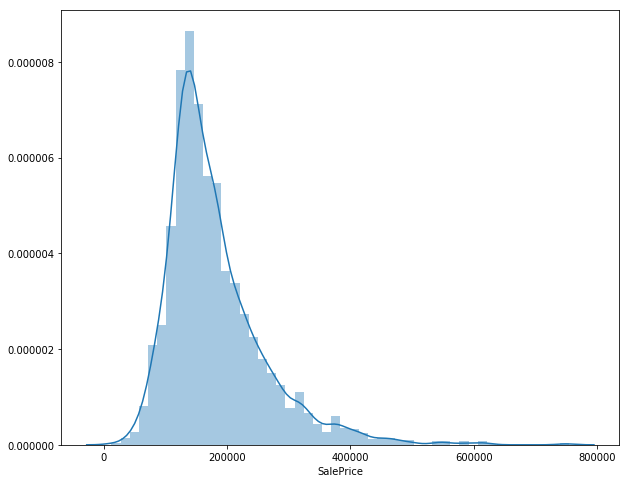

In [17]:
plt.figure(figsize=(10,8))
sns.distplot(dataset['SalePrice'])
# SalePrice is our target column

## Feature Selection

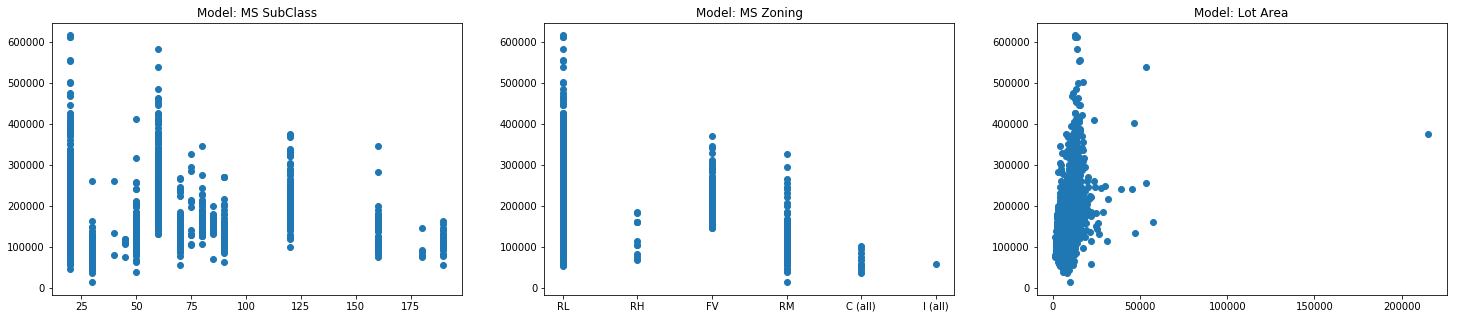

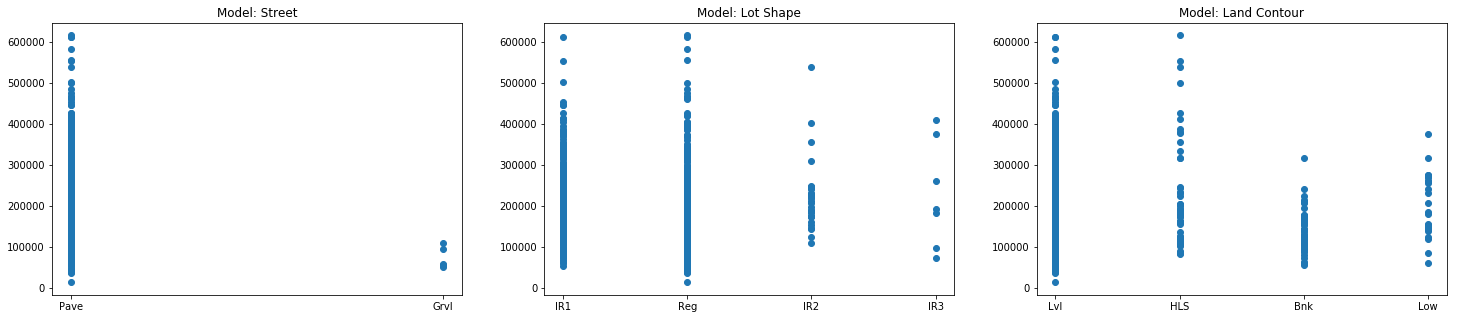

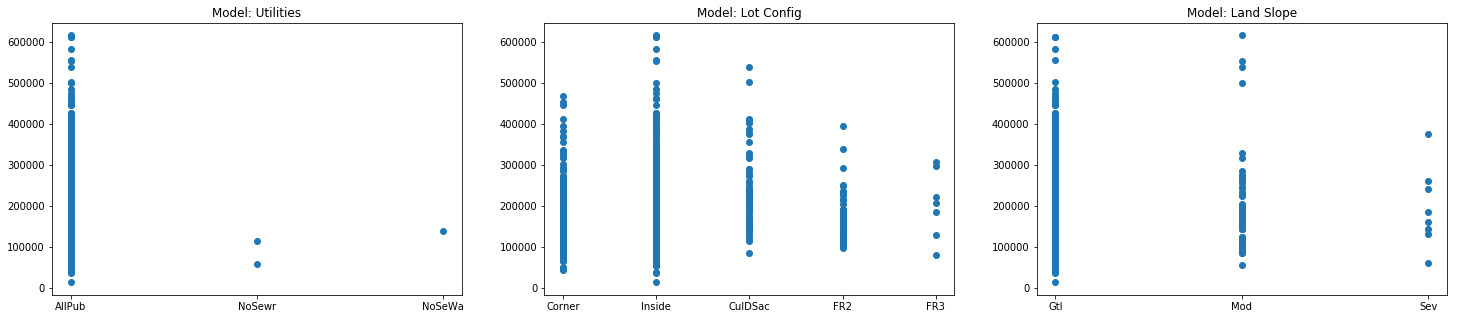

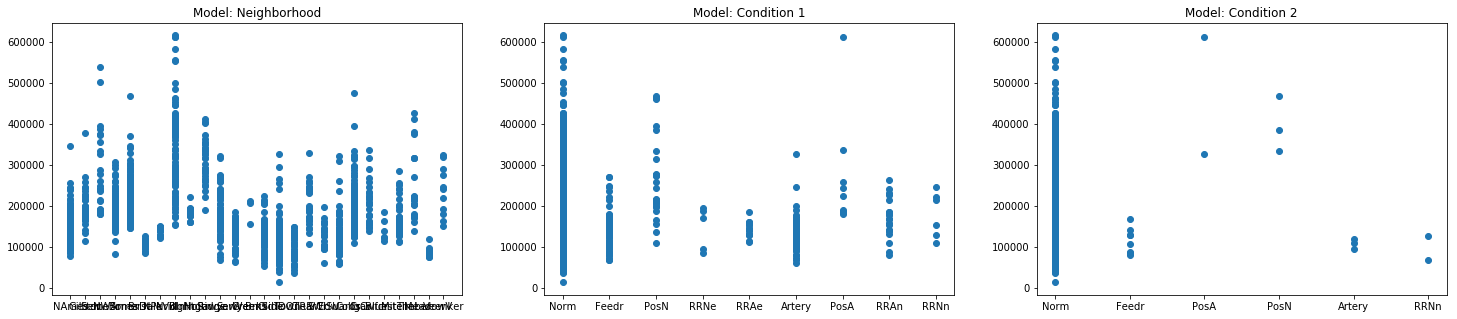

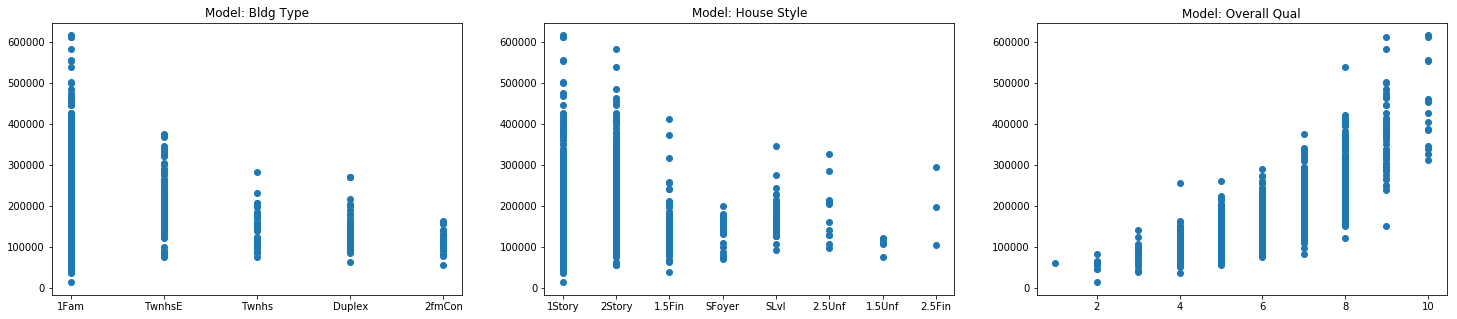

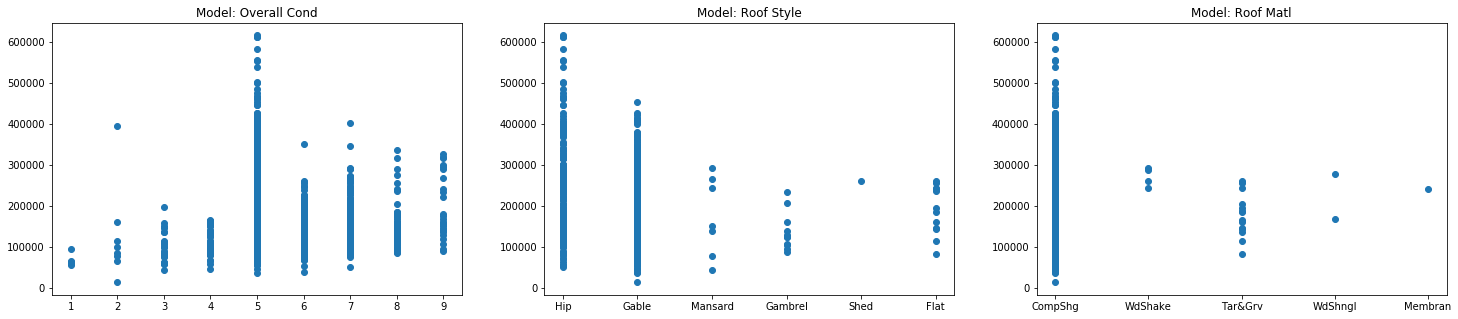

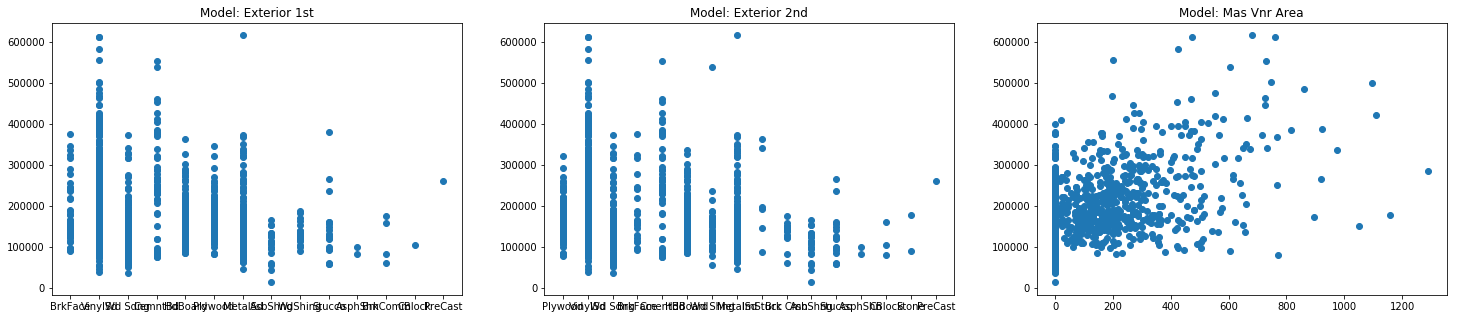

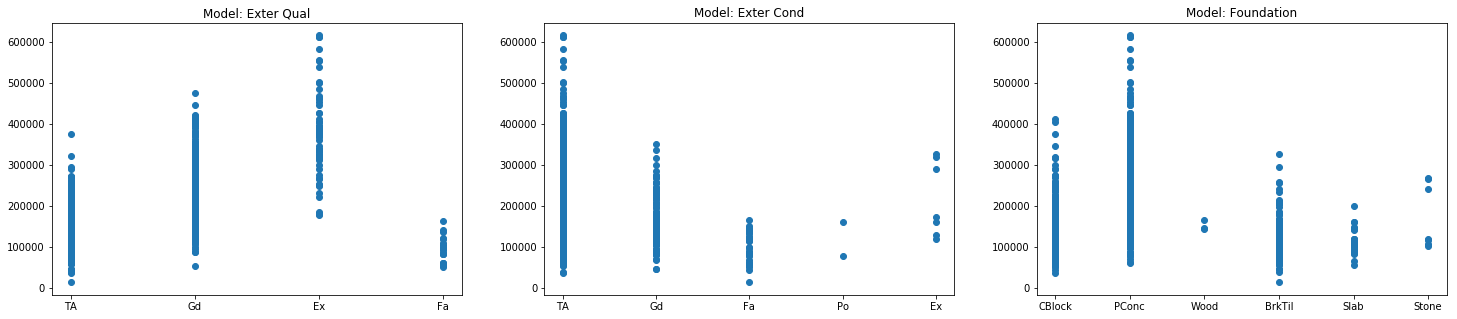

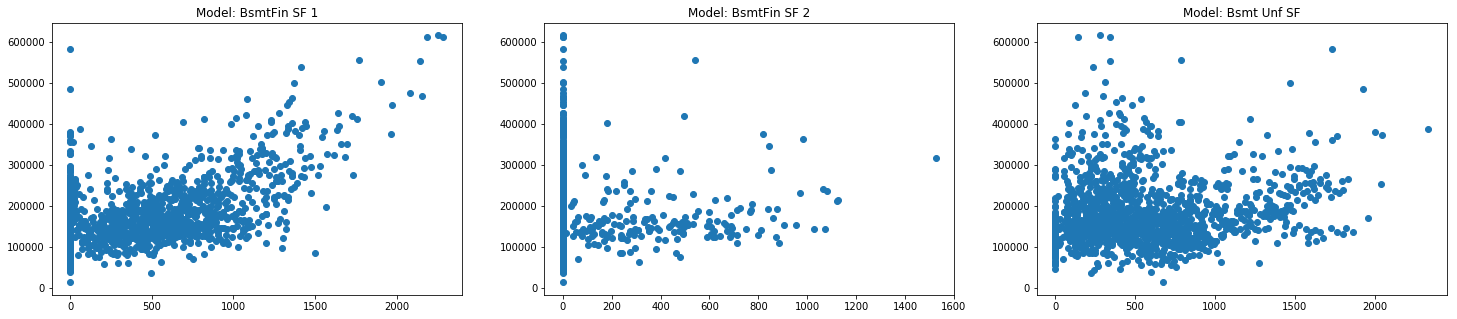

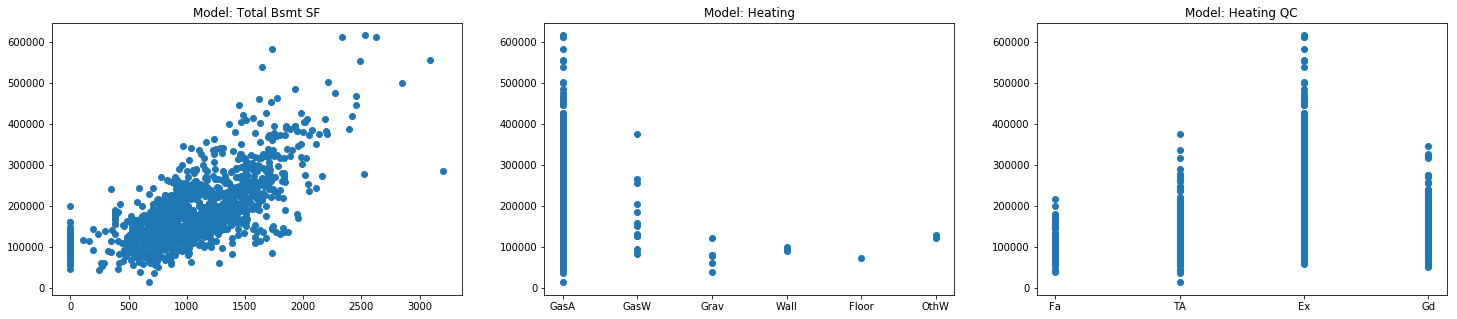

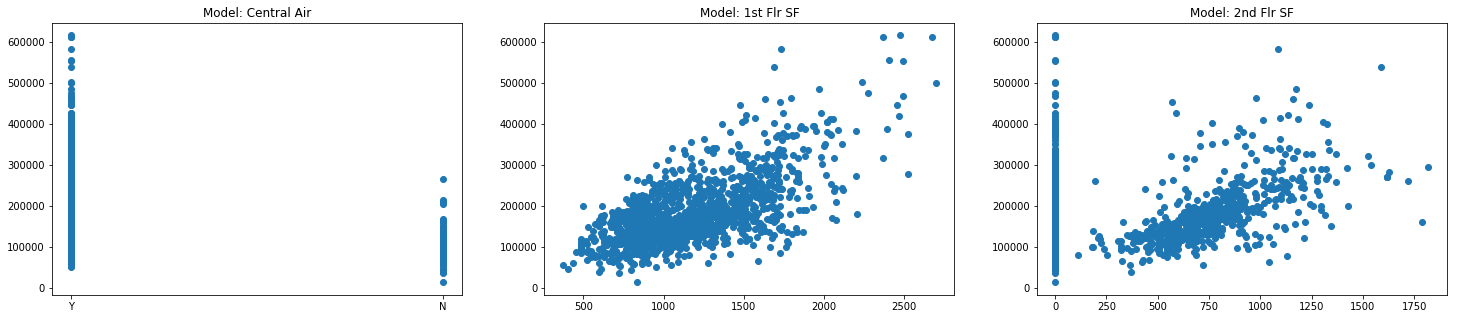

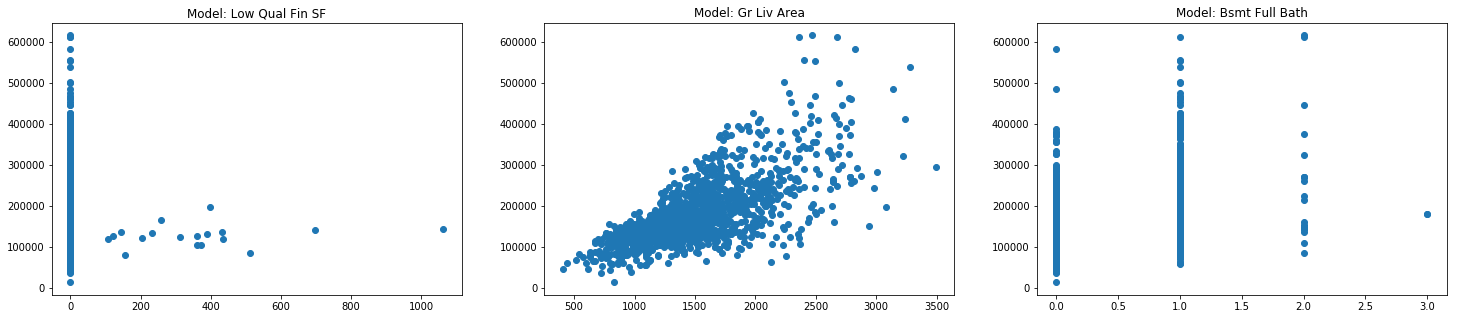

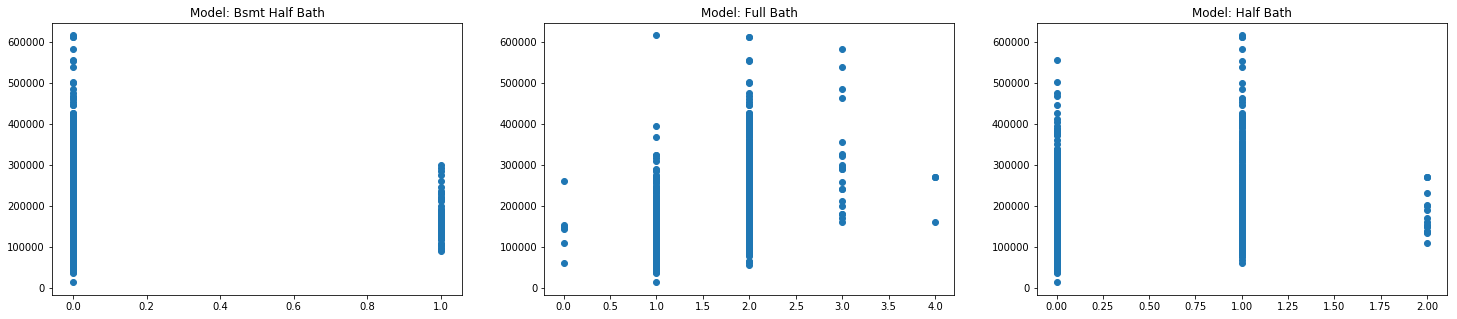

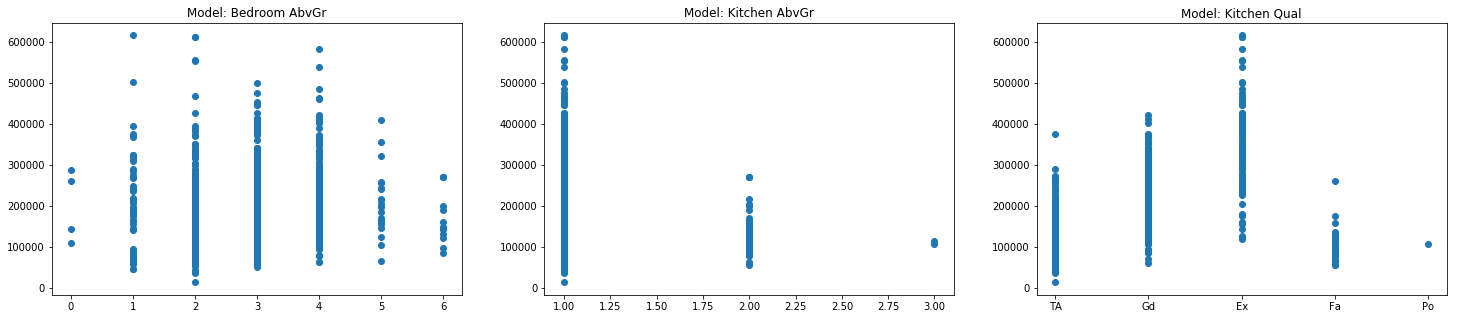

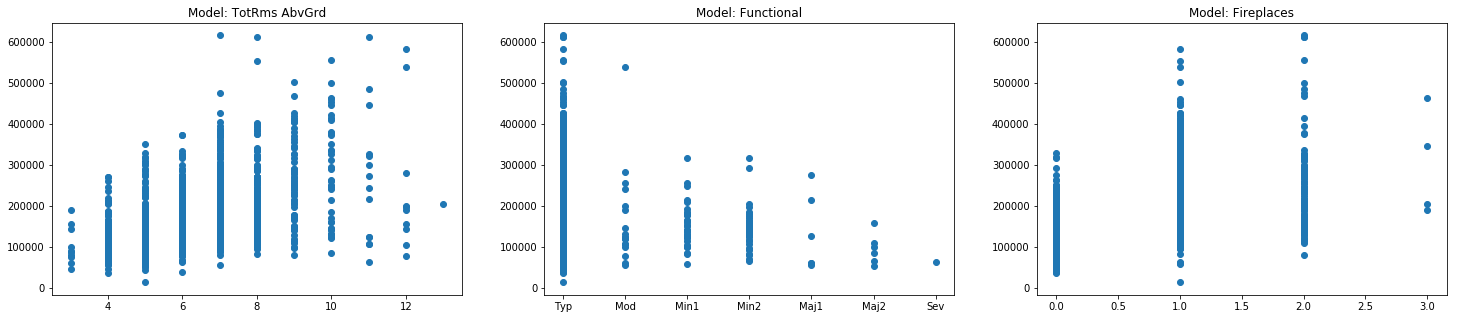

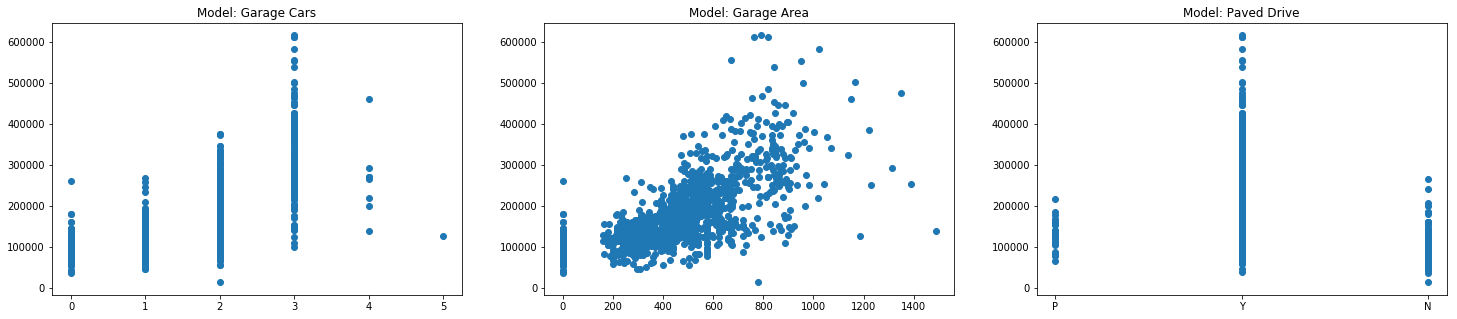

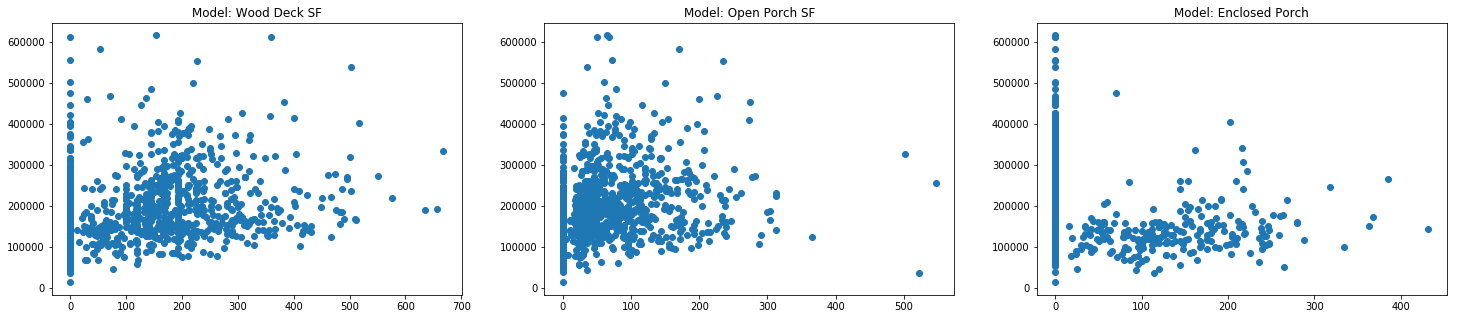

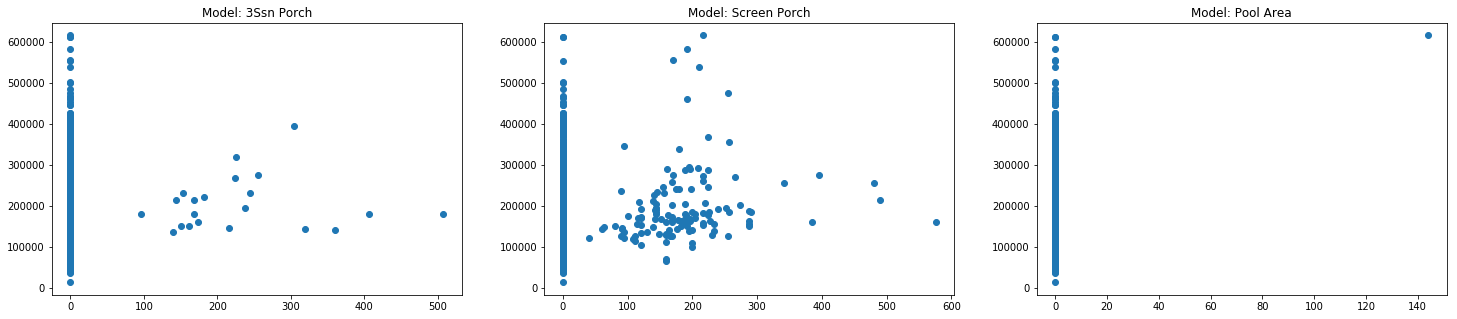

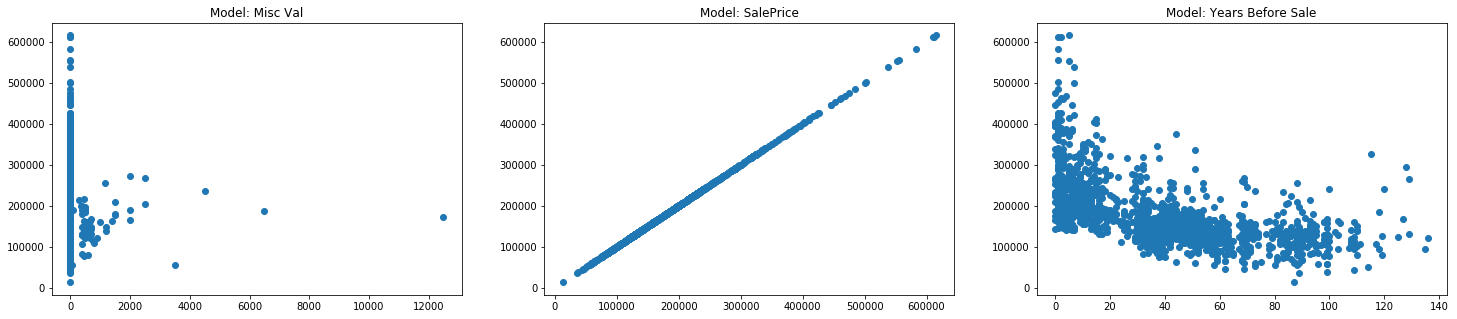

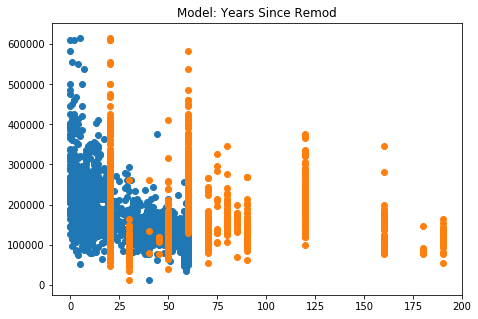

In [18]:
fig_per_time = 3
count=0
train_data = dataset[0:1460]
test_data = dataset[1460:]

for column in dataset.columns:
    plt.figure(count//fig_per_time,figsize=(25,5))
    plt.subplot(1, fig_per_time, np.mod(count,3)+1)
    plt.scatter(train_data[column],train_data['SalePrice'])
    plt.title("Model: {0}".format(column))
    count +=1 

plt.scatter(train_data['MS SubClass'],train_data['SalePrice'])

In [19]:
numeric_data = dataset.select_dtypes(include=['int','float'])
numeric_data.head()

,MS SubClass,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,Years Before Sale,Years Since Remod
0,20,31770,6,5,112.0,639.0,0.0,441.0,1080.0,1656,0,0,1656,1.0,0.0,1,0,3,1,7,2,2.0,528.0,210,62,0,0,0,0,0,215000,50,50
1,20,11622,5,6,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1.0,730.0,140,0,0,0,120,0,0,105000,49,49
2,20,14267,6,6,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1.0,312.0,393,36,0,0,0,0,12500,172000,52,52
3,20,11160,7,5,0.0,1065.0,0.0,1045.0,2110.0,2110,0,0,2110,1.0,0.0,2,1,3,1,8,2,2.0,522.0,0,0,0,0,0,0,0,244000,42,42
4,60,13830,5,5,0.0,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,2.0,482.0,212,34,0,0,0,0,0,189900,13,12


In [20]:
asb_corr_coff = numeric_data.corr()['SalePrice'].abs().sort_values()
asb_corr_coff

BsmtFin SF 2         0.006127
Misc Val             0.019273
3Ssn Porch           0.032268
Bsmt Half Bath       0.035875
Low Qual Fin SF      0.037629
Pool Area            0.068438
MS SubClass          0.085128
Overall Cond         0.101540
Screen Porch         0.112280
Kitchen AbvGr        0.119760
Enclosed Porch       0.128685
Bedroom AbvGr        0.143916
Bsmt Unf SF          0.182751
Lot Area             0.267520
2nd Flr SF           0.269601
Bsmt Full Bath       0.276258
Half Bath            0.284871
Open Porch SF        0.316262
Wood Deck SF         0.328183
BsmtFin SF 1         0.439284
Fireplaces           0.474831
TotRms AbvGrd        0.498574
Mas Vnr Area         0.506983
Years Since Remod    0.534985
Full Bath            0.546118
Years Before Sale    0.558979
1st Flr SF           0.635185
Garage Area          0.641425
Total Bsmt SF        0.644012
Garage Cars          0.648361
Gr Liv Area          0.717596
Overall Qual         0.801206
SalePrice            1.000000
Name: Sale

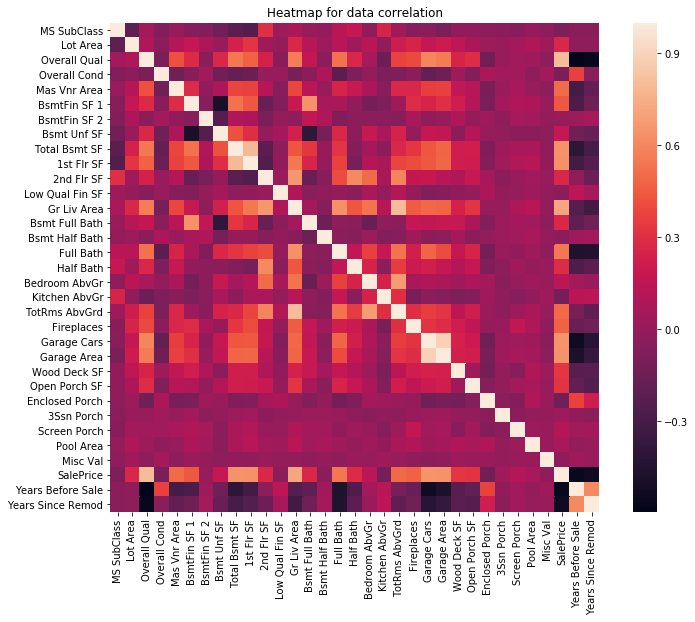

In [21]:
corrdata = numeric_data.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(corrdata, vmax=1, square=True)
plt.title("Heatmap for data correlation")
plt.show()

We will continue with correlation coefficient greater than 0.3

In [22]:
transform_dataset = asb_corr_coff[asb_corr_coff >= 0.3]
transform_dataset

Open Porch SF        0.316262
Wood Deck SF         0.328183
BsmtFin SF 1         0.439284
Fireplaces           0.474831
TotRms AbvGrd        0.498574
Mas Vnr Area         0.506983
Years Since Remod    0.534985
Full Bath            0.546118
Years Before Sale    0.558979
1st Flr SF           0.635185
Garage Area          0.641425
Total Bsmt SF        0.644012
Garage Cars          0.648361
Gr Liv Area          0.717596
Overall Qual         0.801206
SalePrice            1.000000
Name: SalePrice, dtype: float64

In [23]:
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

In [24]:
transform_cat_cols = []
for col in nominal_features:
    if col in dataset.columns:
        transform_cat_cols.append(col)
unique_values = dataset[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
unique_values

Central Air      2
Street           2
Land Contour     4
Lot Config       5
Bldg Type        5
Heating          6
Roof Style       6
Foundation       6
MS Zoning        7
Condition 2      8
House Style      8
Roof Matl        8
Condition 1      9
Exterior 1st    16
MS SubClass     16
Exterior 2nd    17
Neighborhood    28
dtype: int64

In [25]:
drop_nonuniq_cols = unique_values[unique_values>10].index
dataset = dataset.drop(drop_nonuniq_cols, axis=1)
dataset.shape

(2927, 54)

In [26]:
dataset.head()

,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Roof Style,Roof Matl,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,Years Before Sale,Years Since Remod
0,RL,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,1Fam,1Story,6,5,Hip,CompShg,112.0,TA,TA,CBlock,639.0,0.0,441.0,1080.0,GasA,Fa,Y,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,2.0,528.0,P,210,62,0,0,0,0,0,215000,50,50
1,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,Feedr,Norm,1Fam,1Story,5,6,Gable,CompShg,0.0,TA,TA,CBlock,468.0,144.0,270.0,882.0,GasA,TA,Y,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,1.0,730.0,Y,140,0,0,0,120,0,0,105000,49,49
2,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,1Fam,1Story,6,6,Hip,CompShg,108.0,TA,TA,CBlock,923.0,0.0,406.0,1329.0,GasA,TA,Y,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,1.0,312.0,Y,393,36,0,0,0,0,12500,172000,52,52
3,RL,11160,Pave,Reg,Lvl,AllPub,Corner,Gtl,Norm,Norm,1Fam,1Story,7,5,Hip,CompShg,0.0,Gd,TA,CBlock,1065.0,0.0,1045.0,2110.0,GasA,Ex,Y,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,2.0,522.0,Y,0,0,0,0,0,0,0,244000,42,42
4,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,2Story,5,5,Gable,CompShg,0.0,TA,TA,PConc,791.0,0.0,137.0,928.0,GasA,Gd,Y,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,2.0,482.0,Y,212,34,0,0,0,0,0,189900,13,12


#### Select just the remaining text columns and convert to categorical

In [27]:
text_cols = dataset.select_dtypes(include=['object'])
for col in text_cols:
    dataset[col] = dataset[col].astype('category')

text_cols.head()

,MS Zoning,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exter Qual,Exter Cond,Foundation,Heating,Heating QC,Central Air,Kitchen Qual,Functional,Paved Drive
0,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,1Fam,1Story,Hip,CompShg,TA,TA,CBlock,GasA,Fa,Y,TA,Typ,P
1,RH,Pave,Reg,Lvl,AllPub,Inside,Gtl,Feedr,Norm,1Fam,1Story,Gable,CompShg,TA,TA,CBlock,GasA,TA,Y,TA,Typ,Y
2,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,1Fam,1Story,Hip,CompShg,TA,TA,CBlock,GasA,TA,Y,Gd,Typ,Y
3,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,Norm,Norm,1Fam,1Story,Hip,CompShg,Gd,TA,CBlock,GasA,Ex,Y,Ex,Typ,Y
4,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,2Story,Gable,CompShg,TA,TA,PConc,GasA,Gd,Y,TA,Typ,Y


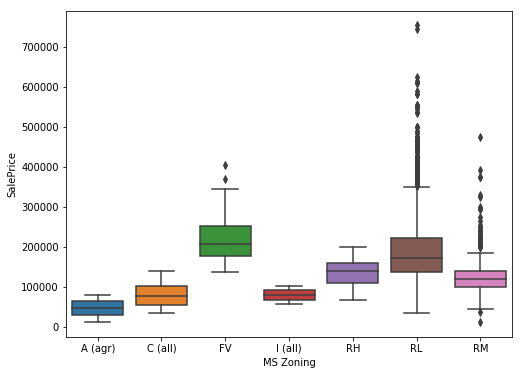

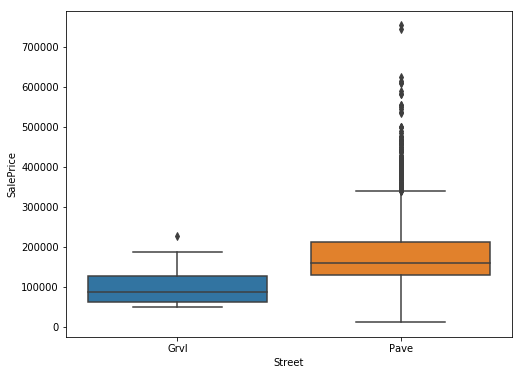

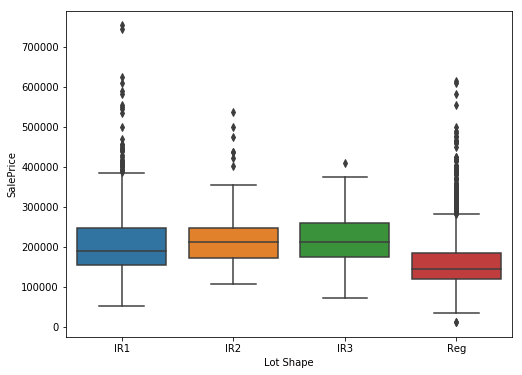

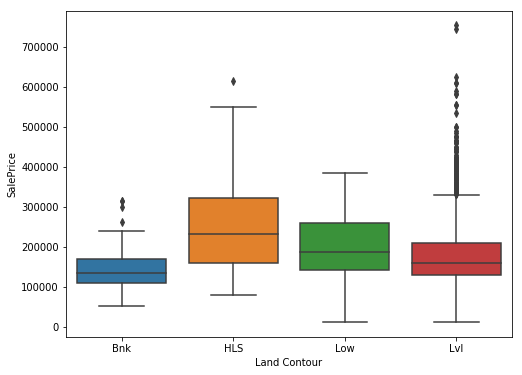

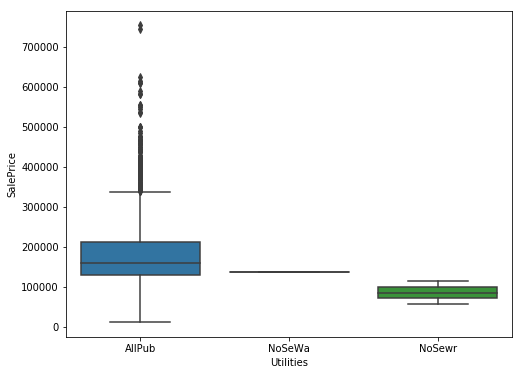

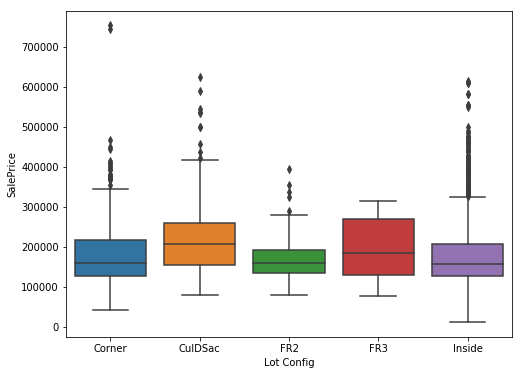

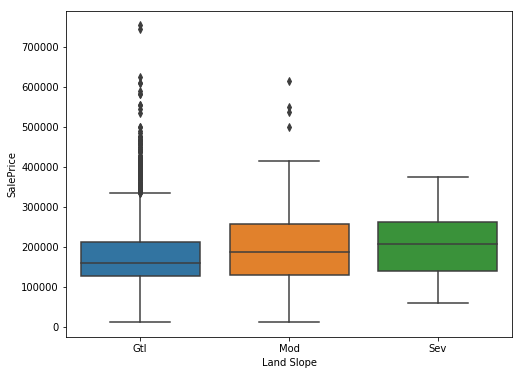

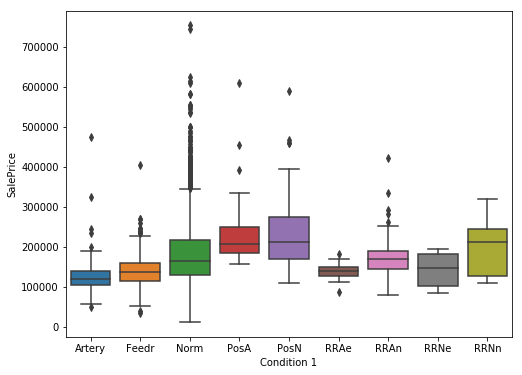

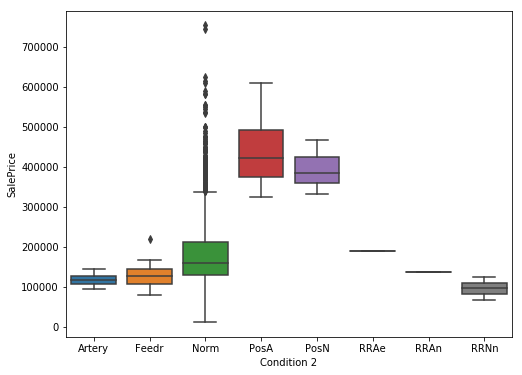

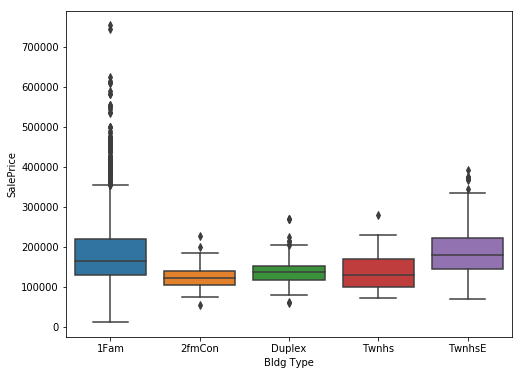

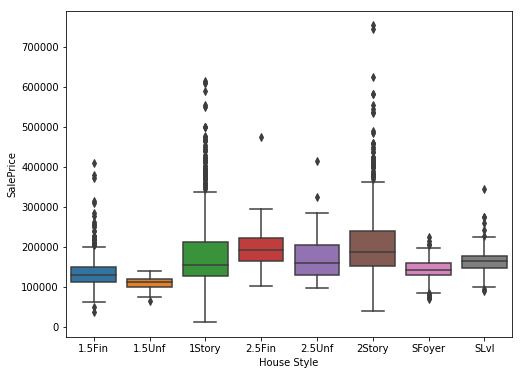

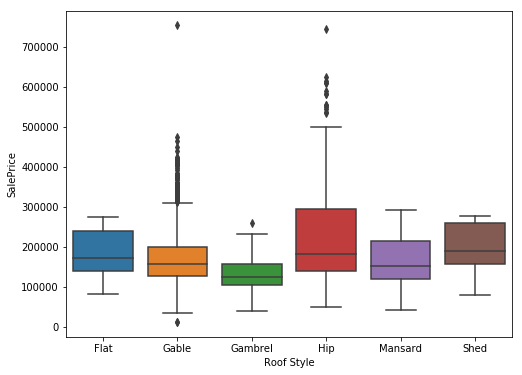

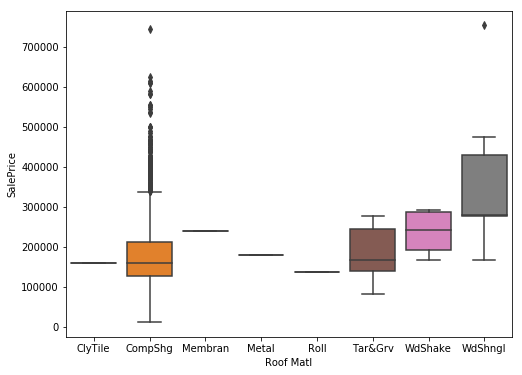

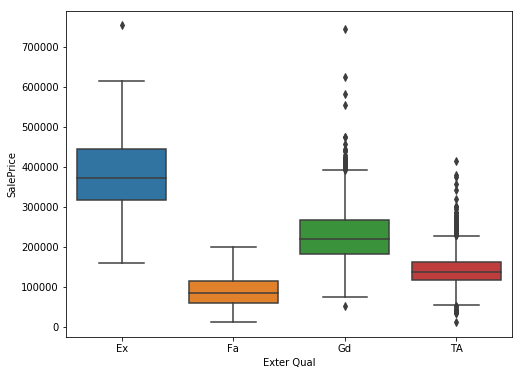

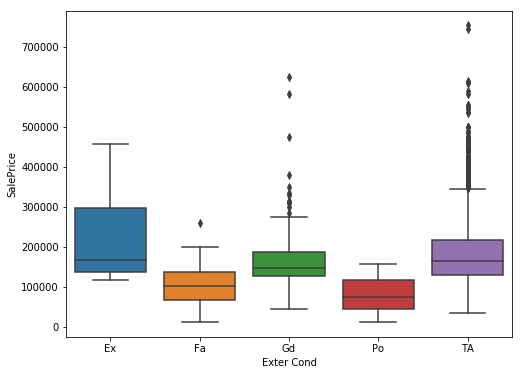

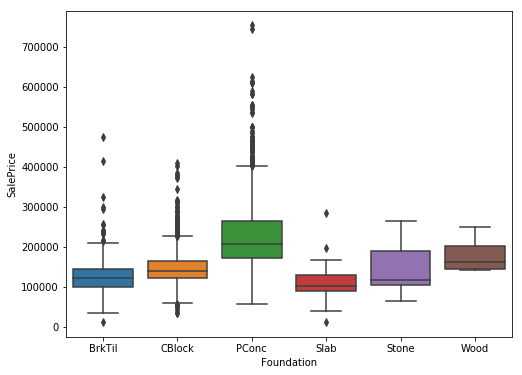

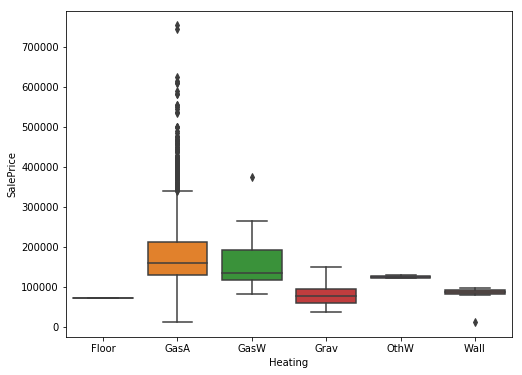

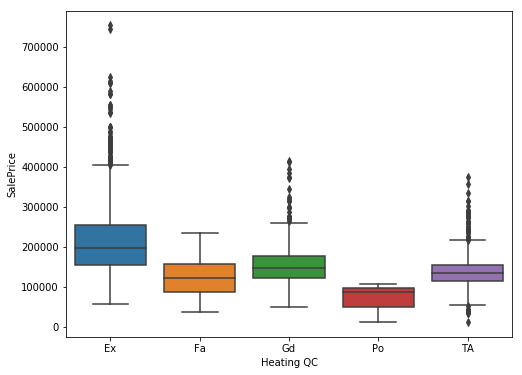

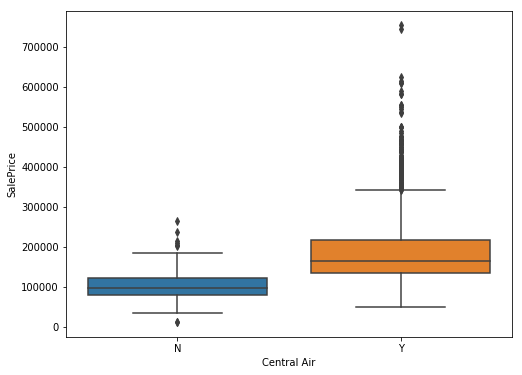

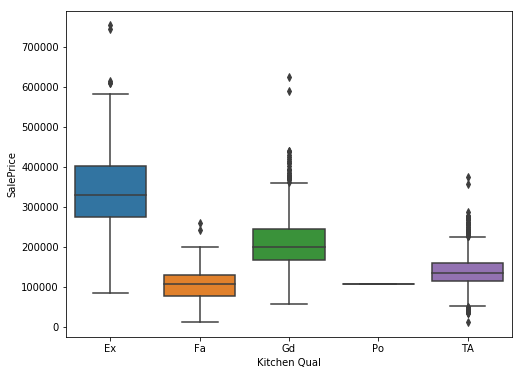

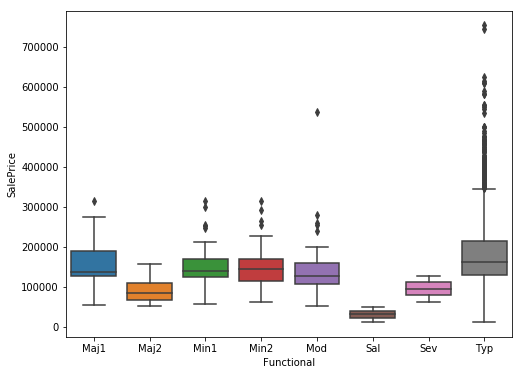

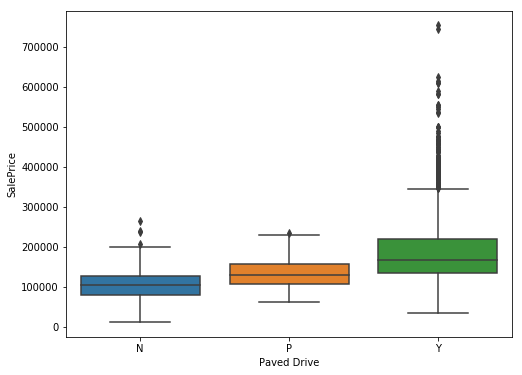

In [28]:
categorical_features = text_cols.columns
feat_cat = dataset[categorical_features]

for feat in feat_cat:
    fig = plt.figure(figsize=(8,6))
    fig = sns.boxplot(x=feat, y='SalePrice', data=dataset)
    plt.show()

In [29]:
pd.get_dummies(dataset.select_dtypes(include=['category']))
new_dataset = pd.concat([dataset, pd.get_dummies(dataset.select_dtypes(include=['category']))], axis=1)
new_dataset = new_dataset.drop(text_cols, axis=1)
new_dataset.head()

,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,Years Before Sale,Years Since Remod,MS Zoning_A (agr),MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Street_Grvl,Street_Pave,Lot Shape_IR1,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Utilities_AllPub,Utilities_NoSeWa,Utilities_NoSewr,Lot Config_Corner,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Land Slope_Gtl,Land Slope_Mod,Land Slope_Sev,Condition 1_Artery,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Artery,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Condition 2_PosN,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn,Bldg Type_1Fam,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1.5Fin,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Roof Style_Flat,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,Roof Matl_ClyTile,Roof Matl_CompShg,Roof Matl_Membran,Roof Matl_Metal,Roof Matl_Roll,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl,Exter Qual_Ex,Exter Qual_Fa,Exter Qual_Gd,Exter Qual_TA,Exter Cond_Ex,Exter Cond_Fa,Exter Cond_Gd,Exter Cond_Po,Exter Cond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Heating QC_Ex,Heating QC_Fa,Heating QC_Gd,Heating QC_Po,Heating QC_TA,Central Air_N,Central Air_Y,Kitchen Qual_Ex,Kitchen Qual_Fa,Kitchen Qual_Gd,Kitchen Qual_Po,Kitchen Qual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Sev,Functional_Typ,Paved Drive_N,Paved Drive_P,Paved Drive_Y
0,31770,6,5,112.0,639.0,0.0,441.0,1080.0,1656,0,0,1656,1.0,0.0,1,0,3,1,7,2,2.0,528.0,210,62,0,0,0,0,0,215000,50,50,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
1,11622,5,6,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1.0,730.0,140,0,0,0,120,0,0,105000,49,49,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
2,14267,6,6,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1.0,312.0,393,36,0,0,0,0,12500,172000,52,52,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
3,11160,7,5,0.0,1065.0,0.0,1045.0,2110.0,2110,0,0,2110,1.0,0.0,2,1,3,1,8,2,2.0,522.0,0,0,0,0,0,0,0,244000,42,42,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
4,13830,5,5,0.0,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,2.0,482.0,212,34,0,0,0,0,0,189900,13,12,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1


### Model traing testing and counting mean error

In [30]:
train_dataset = new_dataset[0:1460]
test_dataset = new_dataset[1460:]
numerical_data = new_dataset.select_dtypes(include=('int','float'))
features = numerical_data.columns.drop("SalePrice")

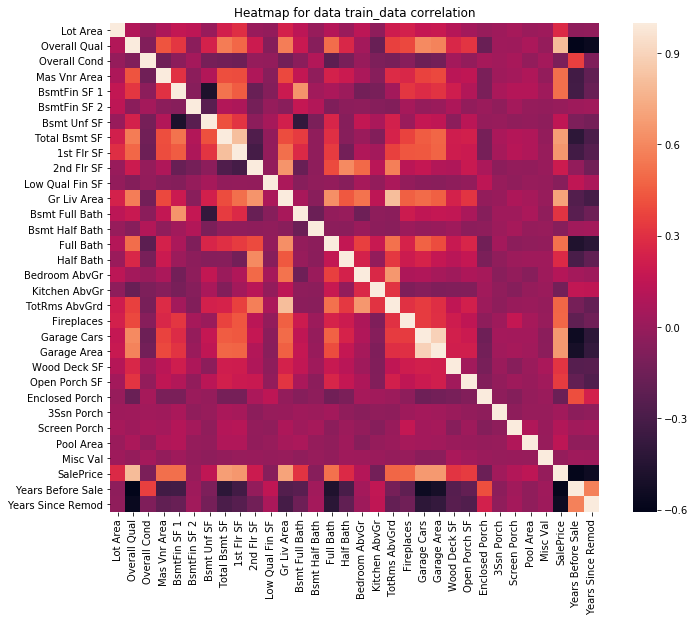

In [31]:
train_corrdata = train_dataset.select_dtypes(include=('int','float')).corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(train_corrdata, vmax=1, square=True)
plt.title("Heatmap for data train_data correlation")
plt.show()

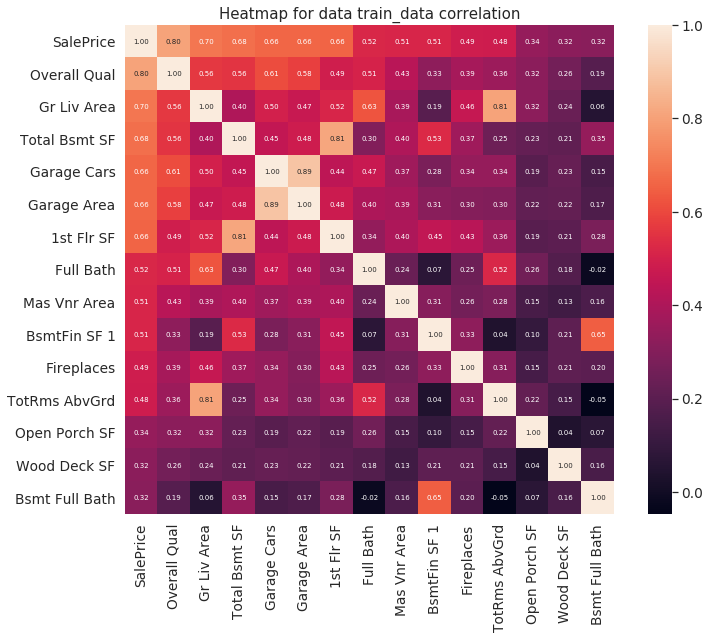

In [32]:
corr_num = 15 #number of variables for heatmap
cols_corr = train_corrdata.nlargest(corr_num, 'SalePrice')['SalePrice'].index
corr_mat_sales = np.corrcoef(train_dataset[cols_corr].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(12, 9))
hm = sns.heatmap(corr_mat_sales, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 7}, yticklabels=cols_corr.values, xticklabels=cols_corr.values)
plt.title("Heatmap for data train_data correlation")
plt.show()

In [33]:
lr = linear_model.LinearRegression()

In [34]:
kFolds = KFold(n_splits=5, shuffle=True)
rmse_values = []

for train_index, test_index in kFolds.split(new_dataset):
    train_data = new_dataset.iloc[train_index]
    test_data = new_dataset.iloc[test_index]
    
    lr.fit(train_data[features], train_data['SalePrice'])
    prediction = lr.predict(test_data[features])
    
    mse = mean_squared_error(prediction, test_data['SalePrice'])
    rmse = np.sqrt(mse)
    rmse_values.append(rmse)

In [35]:
print(rmse_values)
print("Avearge rmse mean: {0}".format(np.mean(rmse_values)))

[27768.998763377873, 33651.48354231805, 40538.93249434162, 30756.345449058586, 29007.581119660044]
Avearge rmse mean: 32344.66827375124
